In [21]:
!pip --version
!pip install pennylane

pip 19.3.1 from /usr/local/lib/python3.6/dist-packages/pip (python 3.6)


In [22]:
import pennylane as qml
qml.about()
from pennylane import numpy as numpy
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline
import math
from scipy import stats

dev = qml.device("default.qubit",wires=2)


Name: PennyLane
Version: 0.7.0
Summary: PennyLane is a Python quantum machine learning library by Xanadu Inc.
Home-page: https://github.com/XanaduAI/pennylane
Author: None
Author-email: None
License: Apache License 2.0
Location: /usr/local/lib/python3.6/dist-packages
Requires: semantic-version, networkx, toml, autograd, appdirs, scipy, numpy
Required-by: 
Platform info:           Linux-4.14.137+-x86_64-with-Ubuntu-18.04-bionic
Python version:          3.6.9
Numpy version:           1.17.4
Scipy version:           1.3.3
Installed devices:
- default.gaussian (PennyLane-0.7.0)
- default.qubit (PennyLane-0.7.0)
- expt.tensornet (PennyLane-0.7.0)
- expt.tensornet.tf (PennyLane-0.7.0)


In [23]:
import pennylane as qml
from pennylane import numpy as np
import math

print("================== start ==============")

# Circuit is hardcoded in several places to only have 2 qubits, despite the following variables.
# For instance, the feature_map() only takes in 1 value "phi",
# whereas multiple values would be needed for more qubits.
num_qubits = 2
# We need to manually evalutate the circuit multiple times since autograd does not work with sample
shots = 10

dev = qml.device("default.qubit", wires=num_qubits, shots=shots)

L = 5

# This should be U_phi for 2 inputs
def U_phi(phi):
    qml.Hadamard(0) @ qml.Hadamard(1)
    qml.RZ(phi[0],wires=[0])
    qml.RZ(phi[1],wires=[1])
    qml.CNOT(wires=[0,1])
    qml.RZ(phi[2],wires=[1])
    qml.CNOT(wires=[0,1])

    qml.Hadamard(0) @ qml.Hadamard(1)
    qml.RZ(phi[0],wires=[0])
    qml.RZ(phi[1],wires=[1])
    qml.CNOT(wires=[0,1])
    qml.RZ(phi[2],wires=[1])
    qml.CNOT(wires=[0,1])


# this should be 1 part of W(theta)
# Should both rotations have the same parameters? or different?
# Figure seems to imply same params
def W_theta_part(param):
    # Entangling section
    qml.CZ(wires=[0,1])
    # Variational section
    qml.RZ(param[2],wires=0)
    qml.RZ(param[3],wires=1)
    qml.RY(param[0],wires=0)
    qml.RY(param[1],wires=1)

# this should be the full circuit then
@qml.qnode(dev)
def circuit(input,params):
    U_phi(input)

    qml.RZ(params[0][2],wires=0)
    qml.RZ(params[0][3],wires=1)
    qml.RY(params[0][0],wires=0)
    qml.RY(params[0][1],wires=1)
    for param in params[1:]:
        W_theta_part(param)

    return [qml.expval(qml.PauliZ(0)),qml.expval(qml.PauliZ(1))]



================== start ==============


In [24]:
def gen_special_unitary():
    unit = stats.unitary_group.rvs(4)
    det = numpy.linalg.det(unit)
    print(det)
    return unit / det ** (1/4)

random_unitary = gen_special_unitary()

@qml.qnode(dev)
def data_set_circuit(input):
    U_phi(input)
    qml.QubitUnitary(random_unitary,wires=[0,1])
    return [qml.expval(qml.PauliZ(0)),qml.expval(qml.PauliZ(1))]

def data_set_mapping(x,y):
    vec = np.array([x,y]) 
    vec = vec * math.pi * 2
    vec = np.append(vec,(math.pi - vec[0])*(math.pi - vec[1]))
    x,y = data_set_circuit(vec)
    return x*y

def build_dataset(size):
    data = []
    neg_count = 0
    pos_count = 0
    while True:
        X = list(np.random.random((2,)))
        Y = data_set_mapping(X[0],X[1])

        # Implement the 0.3 seperation in the dataset
        if Y < -0.15 and neg_count < size:
            neg_count += 1
            data.append([X,-1.0])
        elif Y > 0.15 and pos_count < size:
            pos_count += 1
            data.append([X,1.0])

        # Make sure there are 40 of each label in the set
        if neg_count > size - 1 and pos_count > size - 1:
            break
    np.random.shuffle(data)        
    X = [val[0] for val in data]
    Y = [val[1] for val in data]
    return np.array(X),np.array(Y)

X_data,Y_data = build_dataset(400)
print(Y_data)

(0.8231818632105949+0.5677777911129783j)
[-1. -1. -1. -1.  1.  1. -1. -1.  1. -1.  1. -1.  1. -1. -1. -1.  1. -1.
 -1. -1.  1.  1. -1.  1.  1. -1. -1. -1.  1. -1. -1. -1.  1. -1.  1.  1.
 -1. -1. -1. -1. -1.  1.  1. -1. -1. -1. -1.  1. -1.  1.  1. -1. -1. -1.
 -1. -1. -1.  1.  1.  1.  1.  1. -1.  1.  1.  1. -1.  1.  1. -1.  1.  1.
  1. -1.  1. -1.  1. -1.  1. -1. -1.  1. -1.  1.  1. -1. -1. -1. -1.  1.
 -1. -1. -1.  1.  1. -1.  1. -1. -1. -1.  1.  1. -1.  1.  1.  1.  1. -1.
 -1. -1.  1. -1. -1.  1.  1.  1. -1.  1.  1. -1.  1.  1.  1. -1. -1.  1.
  1.  1. -1.  1.  1.  1. -1.  1.  1. -1.  1.  1. -1.  1.  1. -1. -1.  1.
 -1. -1.  1.  1. -1. -1.  1.  1. -1.  1.  1. -1. -1.  1. -1. -1.  1. -1.
 -1.  1.  1. -1. -1.  1. -1.  1.  1.  1. -1.  1.  1. -1. -1. -1.  1. -1.
  1.  1.  1.  1.  1. -1.  1. -1. -1. -1.  1.  1. -1. -1. -1. -1.  1.  1.
  1.  1. -1.  1. -1. -1.  1.  1.  1. -1. -1.  1.  1. -1. -1. -1.  1. -1.
 -1. -1. -1. -1.  1.  1. -1. -1.  1.  1. -1.  1.  1. -1. -1.  1.  1. -1.
  1. -1.  

In [25]:
# Calculate loss for labels
# I have not yet found a mention of a loss function in the paper
# So it current uses mear square error
def loss(labels,predictions):
    loss = sum((labels - predictions) ** 2)
    loss = loss / len(labels)
    return loss

R = 5
def circ(X,params):
    X = np.array(X)
    X = X * math.pi * 2.0
    X = np.append(X,(math.pi - X[0])*(math.pi - X[1]))
    data = circuit(X,params)
    # This is not entirely the same as the paper.
    # The paper just assignes -1 or 1 based on which value was more present in the shots
    # However since pennylane works with autograd we need to have the output of the
    # circuit be directly used in the calculation of the loss
    # So instead we take the mean value since median does not have a derivative implementation
    return data[0]*data[1]

def cost(params,X,y):
    # Not sure it is nessary, but since a full rotation is 2 pi making
    # the features use the full range seems beneficial
    X = X * math.pi
    preds = np.array([circ(x,params) for x in X])
    ls = loss(y,preds)
    print("LOSS: " + str(ls))
    return ls


# Paper optimizer is not implemented in pennylane so we just use a different one.
# It seems to work file
opt = qml.AdamOptimizer()
# Not sure how the paper initializes parameters
# If i understand some formula that it is initialized as zero
# This is kinda uncommon in ML though
params = np.random.normal(0,0.1,(L+1, 4))
#params = np.zeros((L+1, 4))
print(params)

[[ 0.05596695  0.00382819  0.03281411 -0.01820582]
 [ 0.05242077  0.04068099  0.06280165 -0.14198604]
 [ 0.15165872 -0.04544569 -0.15747308  0.03463246]
 [-0.11180938  0.07199587  0.02202637  0.00742507]
 [-0.04621335 -0.14794808  0.05901478  0.01350141]
 [-0.04056526  0.1077045  -0.0908354  -0.28269513]]


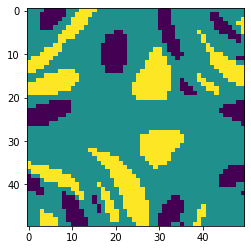

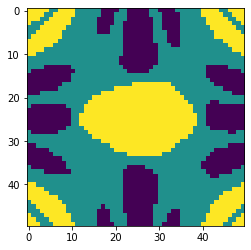

EPOCH: 0
[[ 0.05596695  0.00382819  0.03281411 -0.01820582]
 [ 0.05242077  0.04068099  0.06280165 -0.14198604]
 [ 0.15165872 -0.04544569 -0.15747308  0.03463246]
 [-0.11180938  0.07199587  0.02202637  0.00742507]
 [-0.04621335 -0.14794808  0.05901478  0.01350141]
 [-0.04056526  0.1077045  -0.0908354  -0.28269513]]
LOSS: Autograd ArrayBox with value 1.083665901139184
LOSS: Autograd ArrayBox with value 1.313579558798169
LOSS: Autograd ArrayBox with value 1.0906664198863336
LOSS: Autograd ArrayBox with value 0.7164078424412719
LOSS: Autograd ArrayBox with value 1.2583717759717554
LOSS: Autograd ArrayBox with value 0.8377539609939856
LOSS: Autograd ArrayBox with value 1.2165839663166669
LOSS: Autograd ArrayBox with value 1.2103797643881005
LOSS: Autograd ArrayBox with value 0.9907698929933565
LOSS: Autograd ArrayBox with value 1.2547979237104339
LOSS: Autograd ArrayBox with value 1.196738201590055
LOSS: Autograd ArrayBox with value 1.1630234097742203
LOSS: Autograd ArrayBox with value 0.95

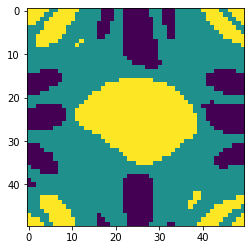

              precision    recall  f1-score   support

         0.0       0.55      0.57      0.56       100
         1.0       0.55      0.53      0.54       100

    accuracy                           0.55       200
   macro avg       0.55      0.55      0.55       200
weighted avg       0.55      0.55      0.55       200

0.55
EPOCH: 1
[[ 0.00935378  0.11824827  0.17751242 -0.10143614]
 [-0.03913906  0.09533622  0.20524182 -0.19771236]
 [ 0.09895096  0.08425368 -0.02643866 -0.02290857]
 [-0.20538078  0.12932079  0.13891992 -0.03084505]
 [-0.10477141 -0.02166705  0.14156801 -0.01176341]
 [-0.13645769  0.16226279  0.02097088 -0.2502879 ]]
LOSS: Autograd ArrayBox with value 0.968900375438867
LOSS: Autograd ArrayBox with value 1.2152099011408461
LOSS: Autograd ArrayBox with value 1.0120775938348343
LOSS: Autograd ArrayBox with value 0.8428610657308141
LOSS: Autograd ArrayBox with value 1.3060607113201563
LOSS: Autograd ArrayBox with value 0.8355554459090468
LOSS: Autograd ArrayBox with 

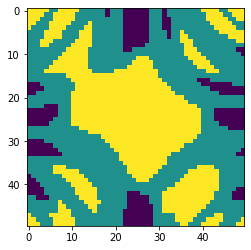

              precision    recall  f1-score   support

         0.0       0.54      0.42      0.47       100
         1.0       0.52      0.64      0.58       100

    accuracy                           0.53       200
   macro avg       0.53      0.53      0.52       200
weighted avg       0.53      0.53      0.52       200

0.53
EPOCH: 2
[[ 0.07160747  0.31408047  0.13090635 -0.24151716]
 [-0.05909493  0.07994503  0.16836788 -0.2758894 ]
 [ 0.16521421  0.28343323 -0.06493111 -0.11400767]
 [-0.25864064  0.10794889  0.13373106 -0.08888127]
 [-0.03910898  0.12280616  0.13379034 -0.06976841]
 [-0.20397489  0.14724208 -0.01585069 -0.29231761]]
LOSS: Autograd ArrayBox with value 1.054329683197906
LOSS: Autograd ArrayBox with value 1.1445780085737653
LOSS: Autograd ArrayBox with value 1.001630512363391
LOSS: Autograd ArrayBox with value 0.9753251654552099
LOSS: Autograd ArrayBox with value 1.336077001832194
LOSS: Autograd ArrayBox with value 0.8570529345351986
LOSS: Autograd ArrayBox with va

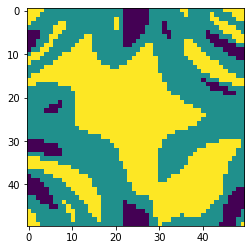

              precision    recall  f1-score   support

         0.0       0.58      0.54      0.56       100
         1.0       0.57      0.61      0.59       100

    accuracy                           0.57       200
   macro avg       0.58      0.57      0.57       200
weighted avg       0.58      0.57      0.57       200

0.575
EPOCH: 3
[[ 0.1311548   0.50649792 -0.01523306 -0.30242929]
 [-0.02078573  0.08631017  0.0176401  -0.2985152 ]
 [ 0.2351709   0.46885542 -0.20088822 -0.13426663]
 [-0.30460276  0.11721306 -0.01070974 -0.17401546]
 [ 0.03752302  0.24204123 -0.00503522 -0.1375264 ]
 [-0.29100206  0.17475932 -0.13748925 -0.35697415]]
LOSS: Autograd ArrayBox with value 1.069467620806869
LOSS: Autograd ArrayBox with value 1.088560599352514
LOSS: Autograd ArrayBox with value 1.0045125588315662
LOSS: Autograd ArrayBox with value 1.0583682401099623
LOSS: Autograd ArrayBox with value 1.2589008449695909
LOSS: Autograd ArrayBox with value 0.9381015179559953
LOSS: Autograd ArrayBox with 

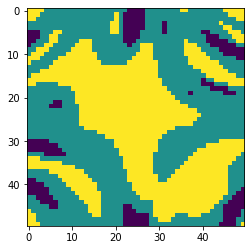

              precision    recall  f1-score   support

         0.0       0.60      0.54      0.57       100
         1.0       0.58      0.64      0.61       100

    accuracy                           0.59       200
   macro avg       0.59      0.59      0.59       200
weighted avg       0.59      0.59      0.59       200

0.59
EPOCH: 4
[[ 0.15208311  0.56405256 -0.03967634 -0.30426733]
 [ 0.04077478  0.08182485  0.00165609 -0.29177203]
 [ 0.25711442  0.52284242 -0.21099875 -0.13383402]
 [-0.34222669  0.12972167 -0.0071437  -0.22373863]
 [ 0.04234006  0.24419333  0.0463198  -0.17398196]
 [-0.34942653  0.21204705 -0.08034484 -0.39617279]]
LOSS: Autograd ArrayBox with value 1.056422825626796
LOSS: Autograd ArrayBox with value 1.0901537012074092
LOSS: Autograd ArrayBox with value 1.0095448714341895
LOSS: Autograd ArrayBox with value 1.0651900918313817
LOSS: Autograd ArrayBox with value 1.2182967249255638
LOSS: Autograd ArrayBox with value 0.9450300694529536
LOSS: Autograd ArrayBox with 

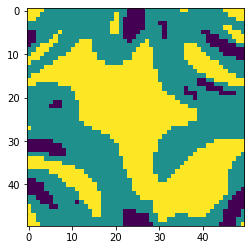

              precision    recall  f1-score   support

         0.0       0.57      0.50      0.53       100
         1.0       0.55      0.62      0.58       100

    accuracy                           0.56       200
   macro avg       0.56      0.56      0.56       200
weighted avg       0.56      0.56      0.56       200

0.56
EPOCH: 5
[[ 0.16025557  0.58918281 -0.05111201 -0.29003671]
 [ 0.09432533  0.08046312  0.00372994 -0.27811071]
 [ 0.26826197  0.55074163 -0.22041282 -0.12580151]
 [-0.38128528  0.14614933  0.0043885  -0.26198947]
 [ 0.02929161  0.22397476  0.09336938 -0.20120438]
 [-0.39926398  0.25090019 -0.02717791 -0.41990406]]
LOSS: Autograd ArrayBox with value 1.044129722675403
LOSS: Autograd ArrayBox with value 1.10048902066163
LOSS: Autograd ArrayBox with value 1.0155435403500865
LOSS: Autograd ArrayBox with value 1.0653876899264647
LOSS: Autograd ArrayBox with value 1.1947806379134658
LOSS: Autograd ArrayBox with value 0.9319537364635737
LOSS: Autograd ArrayBox with va

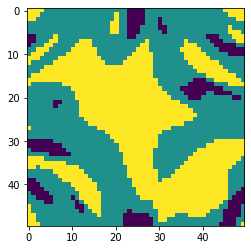

              precision    recall  f1-score   support

         0.0       0.58      0.50      0.54       100
         1.0       0.56      0.64      0.60       100

    accuracy                           0.57       200
   macro avg       0.57      0.57      0.57       200
weighted avg       0.57      0.57      0.57       200

0.57
EPOCH: 6
[[ 0.16569421  0.60559516 -0.05721842 -0.27163472]
 [ 0.13631988  0.08277508  0.01350673 -0.26087111]
 [ 0.27872727  0.57609993 -0.23521137 -0.11386605]
 [-0.42371203  0.16397311  0.01185731 -0.29442809]
 [ 0.01076549  0.20578688  0.13217709 -0.22225578]
 [-0.44620356  0.28823091  0.0155007  -0.43813138]]
LOSS: Autograd ArrayBox with value 1.0342523024768924
LOSS: Autograd ArrayBox with value 1.108590951639566
LOSS: Autograd ArrayBox with value 1.0217054384546642
LOSS: Autograd ArrayBox with value 1.0649714394454688
LOSS: Autograd ArrayBox with value 1.171706328013593
LOSS: Autograd ArrayBox with value 0.9150436716166904
LOSS: Autograd ArrayBox with v

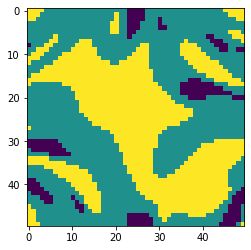

              precision    recall  f1-score   support

         0.0       0.56      0.44      0.49       100
         1.0       0.54      0.66      0.59       100

    accuracy                           0.55       200
   macro avg       0.55      0.55      0.54       200
weighted avg       0.55      0.55      0.54       200

0.55
EPOCH: 7
[[ 0.17061505  0.61794859 -0.05924241 -0.25289582]
 [ 0.17023228  0.08829884  0.02937984 -0.24336733]
 [ 0.29094576  0.60137925 -0.25491403 -0.10170933]
 [-0.46609576  0.18205875  0.01542271 -0.32620767]
 [-0.00937087  0.1952052   0.16607662 -0.24192371]
 [-0.4878812   0.32299917  0.05067202 -0.45432668]]
LOSS: Autograd ArrayBox with value 1.0265013962011775
LOSS: Autograd ArrayBox with value 1.1135560428941444
LOSS: Autograd ArrayBox with value 1.027113382647046
LOSS: Autograd ArrayBox with value 1.063778632708517
LOSS: Autograd ArrayBox with value 1.14811803375671
LOSS: Autograd ArrayBox with value 0.8990350890772515
LOSS: Autograd ArrayBox with val

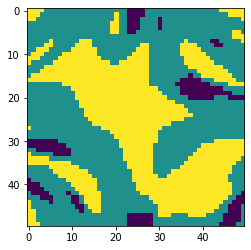

              precision    recall  f1-score   support

         0.0       0.56      0.45      0.50       100
         1.0       0.54      0.65      0.59       100

    accuracy                           0.55       200
   macro avg       0.55      0.55      0.55       200
weighted avg       0.55      0.55      0.55       200

0.55
EPOCH: 8
[[ 0.1751931   0.62654172 -0.05843907 -0.23505211]
 [ 0.19891199  0.09592238  0.04998292 -0.22692483]
 [ 0.30514151  0.62505265 -0.27928897 -0.09090515]
 [-0.50634535  0.19960572  0.01562233 -0.35859532]
 [-0.03039452  0.19405476  0.19710821 -0.26177883]
 [-0.52264893  0.35365221  0.08053354 -0.46898841]]
LOSS: Autograd ArrayBox with value 1.0203904739765453
LOSS: Autograd ArrayBox with value 1.1158518003778213
LOSS: Autograd ArrayBox with value 1.0308644489754843
LOSS: Autograd ArrayBox with value 1.0616104212028008
LOSS: Autograd ArrayBox with value 1.126240569957318
LOSS: Autograd ArrayBox with value 0.8856668163352189
LOSS: Autograd ArrayBox with 

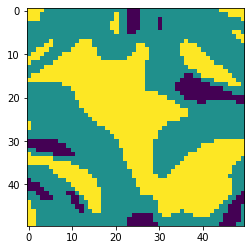

              precision    recall  f1-score   support

         0.0       0.57      0.42      0.48       100
         1.0       0.54      0.68      0.60       100

    accuracy                           0.55       200
   macro avg       0.55      0.55      0.54       200
weighted avg       0.55      0.55      0.54       200

0.55
EPOCH: 9
[[ 0.17918537  0.63059874 -0.05588666 -0.21828001]
 [ 0.22469097  0.10457778  0.07407939 -0.21147045]
 [ 0.32088297  0.64538146 -0.30802513 -0.0814761 ]
 [-0.543877    0.21629702  0.01298572 -0.39083535]
 [-0.05288     0.20272331  0.22704373 -0.28123418]
 [-0.5502309   0.37840626  0.10702794 -0.48160692]]
LOSS: Autograd ArrayBox with value 1.015051918031778
LOSS: Autograd ArrayBox with value 1.1160805485320402
LOSS: Autograd ArrayBox with value 1.0322891361401745
LOSS: Autograd ArrayBox with value 1.0583829095610473
LOSS: Autograd ArrayBox with value 1.1084229281655218
LOSS: Autograd ArrayBox with value 0.874923917607164
LOSS: Autograd ArrayBox with v

In [0]:

def plot_dataset():
    num_samples = 50.0
    data = [[data_set_mapping(x/num_samples,y/num_samples) for x in range(int(num_samples))] for y in range(int(num_samples))]
    data = np.array(data)
    data[data < -0.15] = -1
    data[data > 0.15] = 1
    data[np.logical_and(data != -1,data != 1)] = 0
    plt.imshow(data,interpolation='nearest') 
    plt.show()

def plot_classifier():
    num_samples = 50.0
    data = [[circ([x/num_samples,y/num_samples],params) for x in range(int(num_samples))] for y in range(int(num_samples))]
    data = np.array(data)
    data[data < -0.15] = -1
    data[data > 0.15] = 1
    data[np.logical_and(data != -1,data != 1)] = 0
    plt.imshow(data,interpolation='nearest') 
    plt.show()

# Evalutates the resulting circuit
def evaluate():
    X_test,Y_test = build_dataset(100)
    X_test = np.array(X_test) * math.pi
    preds = np.array([circ(x,params) for x in X_test])
    preds[preds < 0] = 0
    preds[preds > 0] = 1
    Y_test[Y_test < 0] = 0
    Y_test[Y_test > 0] = 1
    print(metrics.classification_report(Y_test,preds))
    print(metrics.accuracy_score(Y_test,preds))

plot_dataset()
plot_classifier()
batch_size =10
for i in range(200):
    print("EPOCH: " + str(i))
    print(params)
    for i in range(len(X_data) // batch_size):
        idx = i * batch_size
        X_batch = X_data[idx:idx+batch_size]
        Y_batch = Y_data[idx:idx+batch_size]
        params = opt.step(lambda v: cost(v,X_batch,Y_batch),params)
    plot_classifier()
    evaluate()